# Second Approach: Using Detuning Map And Pulse Optimization To Generate The Maximum Weighted Independent Set

## Introduction

In this notebook, we explore a hybrid classical-quantum algorithm for solving an antenna placement optimization problem. The objective is to maximize the coverage of a region while minimizing interference between antennas. This problem involves a vast search space of possible antenna positions, which poses a significant computational challenge. To address this, we first use a **greedy algorithm** to generate a grid of N points. Then we use a **Neutral Atom Quantum Computing (NAQC)** to embed this graph in a register, and optimize the pulse parameters to get the **Maximum Weighted Independent Set** (MWIS) corresponding to the best coverage. In order to have different detuning for each qubits, we also implement a detuning map channel that is optimized alongside the pulse parameters.

**Note:** this approach do not give good solution as the initial grid is fixed and the final coverage depends on the quality of the initial grid.

### Hybrid Classical-Quantum Workflow

The algorithm proceeds as follows:

1. **Grid Initialization**: We Place k grid points on a 2D plane based on population coordinates using a greedy algorithm. It ensures that each point covers part of the population and attempts to respect minimum distance constraints. Finally, if there are no valid placements, adds the point at the location with the lowest grid density.
2. **Channel Declarations**: We define the *detuning map* channel with an initial weight for each qubit proportional to its population coverage, and retrive the pulse parameters that were optimized in `pulse_optimization.ipynb`.
3. **Optimization**: This hybrid approach use an **optimisation function** based on Gaussian processes `gp_minimize` from `scikit-optimize` to change the pulse parameters and detuning map weights in order to get the MWIS corresponding to the maximum coverage.


In [21]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.spatial import KDTree, distance_matrix
from scipy.spatial.distance import pdist, squareform
import json
from skopt import gp_minimize
# graph representation
import networkx as nx
# Pulser imports
import pulser as pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform

### Extract the city data

In [22]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[0]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x_arr = np.array(data['x'])
y_arr = np.array(data['y'])

In [23]:
# function to compute coverage of an array of grid_points
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    return z_coverage
    

### Generate a grid

We generate a triangular grid and adaptively select `max_grid_points` from the triangular grid. We take `max_grid_points` equal to 10 to minimize the time taken for Qutip emulator to run the quantum program. 

In [24]:
def generate_greedy_grid(population_x, population_y, k, min_distance, coverage_radius):
    """
    Places k grid points on a 2D plane based on population coordinates using a greedy algorithm.
    Ensures that each point covers part of the population and attempts to respect minimum distance 
    constraints. If there are no valid placements, adds the point at the location with the lowest grid density.

    Parameters:
    - population_x (array-like): Array of x-coordinates of the population.
    - population_y (array-like): Array of y-coordinates of the population.
    - k (int): Number of grid points (antennas) to place.
    - min_distance (float): Minimum required distance between grid points.
    - coverage_radius (float): Radius within which a grid point must cover some population.

    Returns:
    - grid_points (ndarray): Array of shape (k, 2) with the selected grid points (x, y).
    """
    
    # Combine population coordinates
    population_coords = np.column_stack((population_x, population_y))
    grid_points = []

    # Function to check if a point is at least min_distance away from all existing grid points
    def is_valid_point(point, others, min_dist):
        return all(np.linalg.norm(point - np.array(p)) >= min_dist for p in others)

    # Function to calculate the coverage count of a point
    def coverage_count(point, population, radius):
        distances = np.linalg.norm(population - point, axis=1)
        return np.sum(distances <= radius)

    # Greedily place points
    for _ in range(k):
        best_point = None
        best_coverage = -1
        fallback_candidates = []  # Keep candidates for low-density placement

        # Evaluate each population point as a candidate for placing a new antenna
        for candidate in population_coords:
            # If candidate respects minimum distance, prioritize it
            if is_valid_point(candidate, grid_points, min_distance):
                count = coverage_count(candidate, population_coords, coverage_radius)
                
                # Choose the candidate with the highest coverage
                if count > best_coverage:
                    best_coverage = count
                    best_point = candidate

            # Collect fallback candidates for low-density placement
            elif best_point is None:
                fallback_candidates.append(candidate)
        
        # If no valid point meets the minimum distance, use fallback candidates
        if best_point is None and fallback_candidates:
            # Select the candidate in the area with the lowest density
            best_point = max(
                fallback_candidates,
                key=lambda x: np.min(np.linalg.norm(np.array(grid_points) - x, axis=1)) if grid_points else 0
            )

        # Add the chosen point to the grid points
        grid_points.append(best_point)

    return np.array(grid_points)


In [25]:
# Define parameters
population_x = x_arr
population_y = y_arr
# Radius of coverage for each antenna
R_antennas = 25
# Maximum number of antennas
max_grid_points = 8
# Find grid points and get the k-means model for clustering
grid_points = generate_greedy_grid(population_x, population_y, max_grid_points, R_antennas*2+1e-3, R_antennas)
# Calculate final coverage for the selected grid layout
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)

/var/folders/2p/l5x_c52n7g7c1nx8x8v82j7c0000gn/T/ipykernel_5175/1218767699.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(population_x, population_y, cmap='viridis', marker='o', alpha=0.5, label='Population')


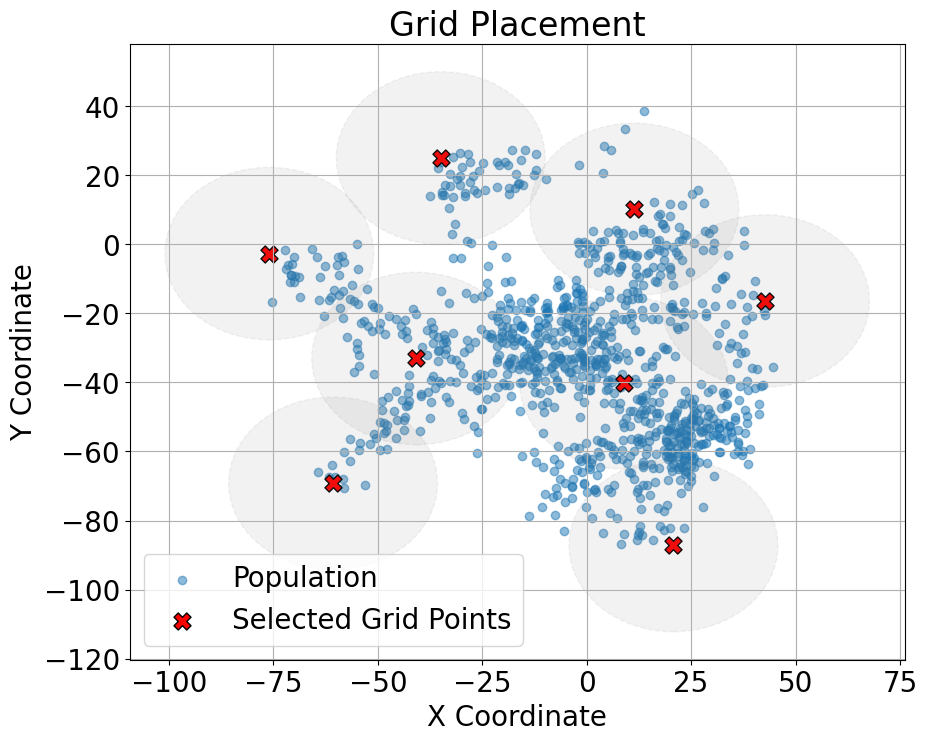

In [26]:
# Define the radius of coverage for each grid point
R_coverage = 25  # Adjust this value as needed for your coverage radius

# Plot population points with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(population_x, population_y, cmap='viridis', marker='o', alpha=0.5, label='Population')

# Plot grid points (cluster centroids)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c='red', s=150, edgecolor='black', marker='X', label='Selected Grid Points')

# Add coverage circles around each grid point
for (x, y) in grid_points:
    coverage_circle = plt.Circle((x, y), R_coverage, color='gray', alpha=0.1, linestyle='--')
    plt.gca().add_patch(coverage_circle)

# Labels and legend with adjusted font sizes
plt.xlabel('X Coordinate', fontsize=20)
plt.ylabel('Y Coordinate', fontsize=20)
plt.title('Grid Placement', fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()


### Device selection

We choose the `MockDevice` and embedd the `grid_points` to the register coordinate with appropriate scaling.

In [27]:
device_used = MockDevice
# create an UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
factor = 6/val
coords = coords*factor # Normalize to 6 b.c. minimum distance on real NAQC is around 6um

# Load optimized pulse parameters from file
optimized_data = np.load('media/optimized_values.npz')
T = optimized_data['T'] # Total pulse duration
omega_max = float(optimized_data['omega_max']) # Maximum Rabi frequency
delta_0 = float(optimized_data['delta_0']) # Initial detuning
delta_f = float(optimized_data['delta_f']) # Final detuning
# Random instance of the parameter space
params = optimized_data['param']
m = (int)(len(params)/2) # Number of parameters for the ramp
amp_params = params[:m] # Amplitude parameters
det_params = params[m:] # Detuning parameters

# scaling of the graph to map it inside the register
rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
R_antennas = 25*factor
factor_for_rydberg_scaling = (rydberg_radius + 1e-3)/(2*R_antennas)
R_antennas = R_antennas * factor_for_rydberg_scaling
coords = coords * factor_for_rydberg_scaling

# Number of qubits
N = len(coords)
# Number of samples to probe
N_samples = 1000

# Noise configuration
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}
print('Omega_max:', omega_max)
print('Rydberg radius:', rydberg_radius)
print('Delta_0:', delta_0)
print('Delta_f:', delta_f)
print('Minimum distance:', np.min(pdist(coords)))

Omega_max: 6.283185307179586
Rydberg radius: 9.756753962298905
Delta_0: -37.69911184307752
Delta_f: 12.566370614359172
Minimum distance: 8.006944620911124


### Extract Q for the QUBO cost function

In [28]:
# interaction coefficients U_ij
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
# fill the diagonal with negative of the coverage of each grid point
np.fill_diagonal(Q, -z_coverage)

In [29]:
trap_coordinates = np.array(grid_points)
weights_param = 1 - np.array(z_coverage/np.max(z_coverage))
n_weights = len(weights_param)

# Print the weights for each antenna
for i, weight in enumerate(weights_param):
    print(f"Antenna {i+1}: Coverage = {z_coverage[i]}, Weight = {weight:.2f}")

Antenna 1: Coverage = 377.0, Weight = 0.00
Antenna 2: Coverage = 159.0, Weight = 0.58
Antenna 3: Coverage = 107.0, Weight = 0.72
Antenna 4: Coverage = 50.0, Weight = 0.87
Antenna 5: Coverage = 65.0, Weight = 0.83
Antenna 6: Coverage = 36.0, Weight = 0.90
Antenna 7: Coverage = 27.0, Weight = 0.93
Antenna 8: Coverage = 65.0, Weight = 0.83


### Create the register

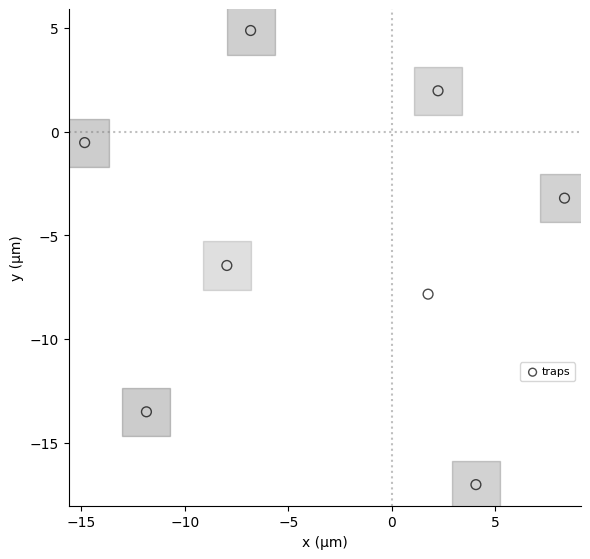

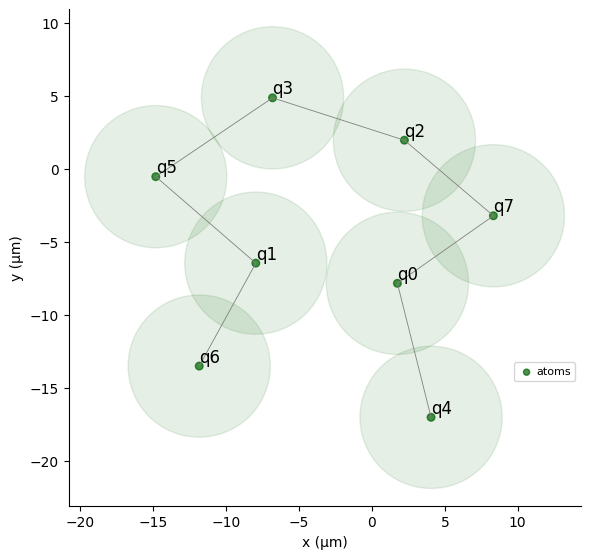

In [30]:
reg = Register.from_coordinates(
    coords, center=False, prefix="q"
)
det_map_from_reg = reg.define_detuning_map(
    {
        f"q{i}": weights_param[i] for i in range(len(weights_param))
    }  # mapping between qubit ids and weights
)

det_map_from_reg.draw()
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

{0: Text(1.7462353709168794, -7.831400185421015, '0'),
 7: Text(8.331073808489574, -3.1982079083135706, '7'),
 4: Text(4.055480189483949, -17.02410920411047, '4'),
 2: Text(2.2271673274362143, 1.9838271970183474, '2'),
 1: Text(-7.965091587087381, -6.44773585941268, '1'),
 5: Text(-14.827896147528769, -0.5167029542475742, '5'),
 3: Text(-6.8185102251319565, 4.892442257161979, '3'),
 6: Text(-11.846591433275321, -13.509235822683774, '6')}

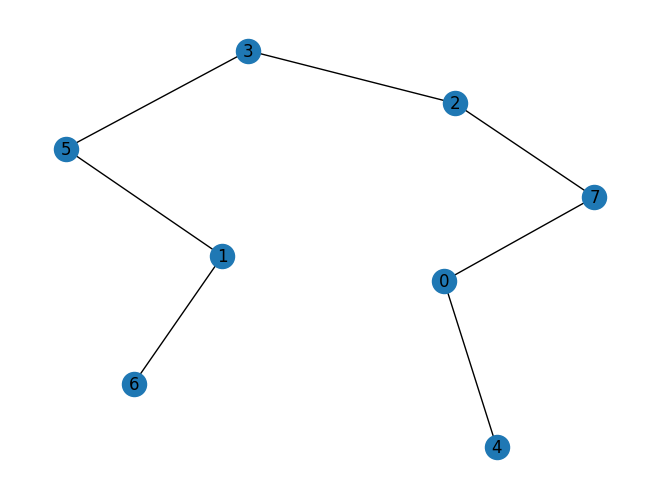

In [31]:
graph = nx.Graph()
edges = KDTree(coords).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

In [32]:
def create_interp_pulse(amp_params, det_params):
    return Pulse(
        InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]),
        InterpolatedWaveform(T, [delta_0, *det_params, delta_f]),
        0,
    )

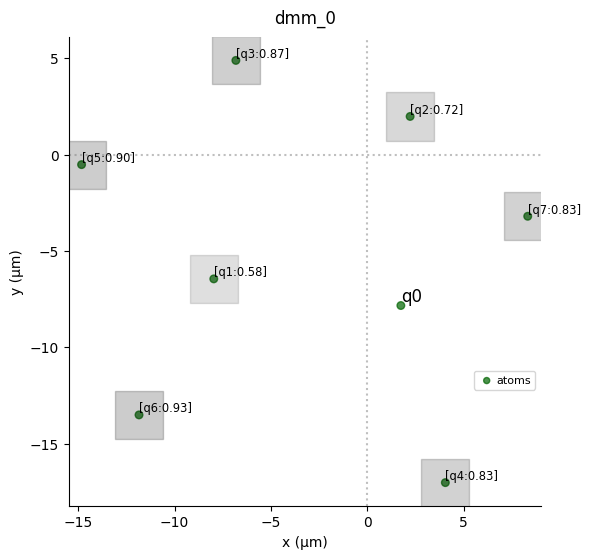

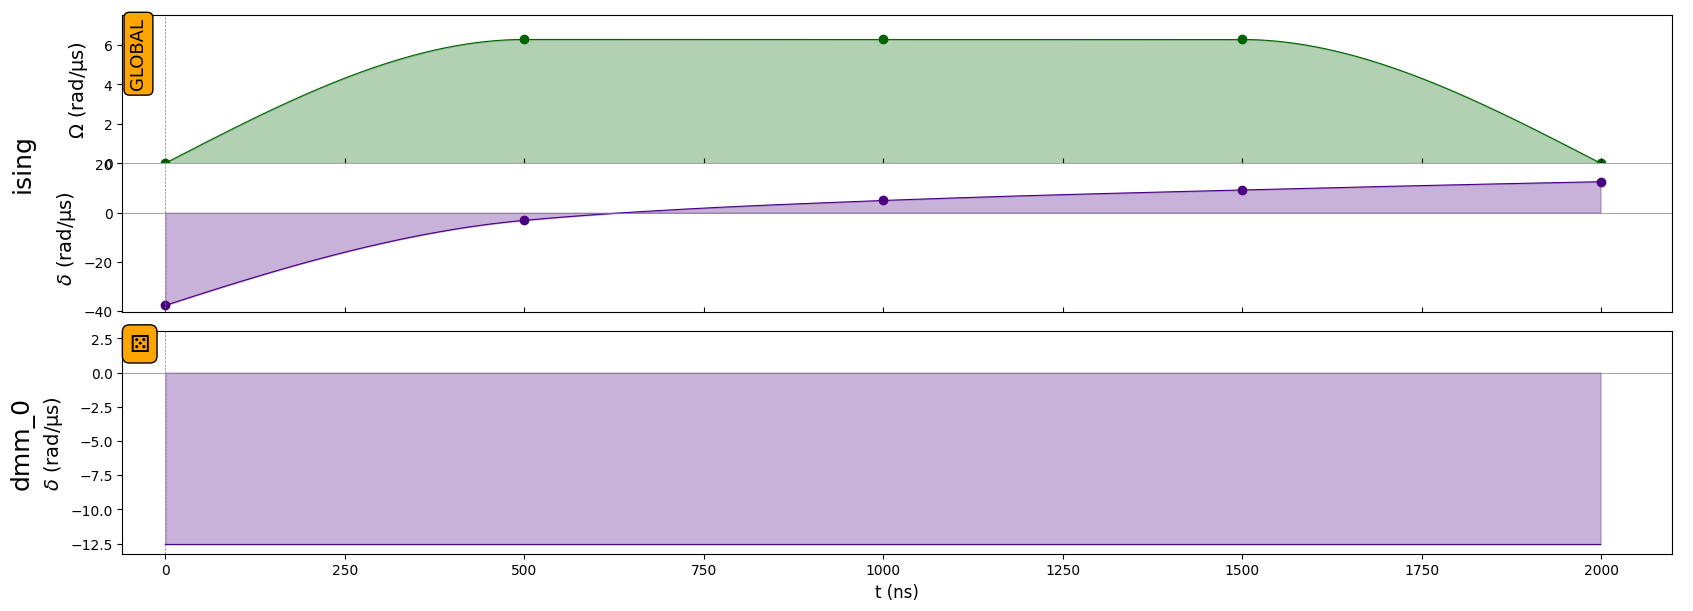

In [33]:
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(amp_params, det_params), "ising")

total_duration = T
waveform = ConstantWaveform(total_duration, -delta_f)

seq.config_detuning_map(det_map_from_reg, "dmm_0")
# Concatenate the waveforms
seq.add_dmm_detuning(waveform, "dmm_0")
seq.draw(draw_detuning_maps=True)

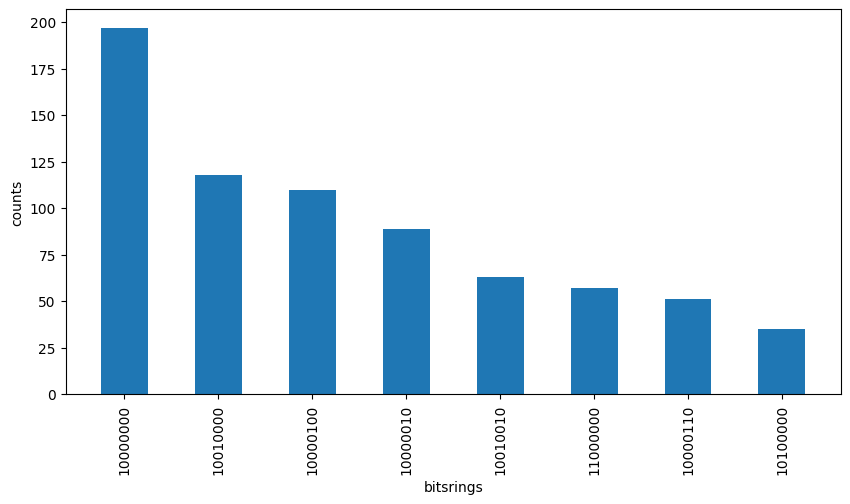

In [34]:
simulator = QutipEmulator.from_sequence(seq)
results = simulator.run()
results = simulator.run(progress_bar=False)
count_dict = results.sample_final_state(N_samples=N_samples)
most_frequent = {k:v for k,v in count_dict.items() if v>20}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

# Optimization

In [35]:
# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

In [36]:
# Function to return the size of the Maximum Independent Set (MIS)
def mis_coverage(graph, bitstring):
    """
    Calculates the coverage of the independent set represented by the bitstring for a given graph.
    
    Parameters:
    - graph: The graph in which the independent set is being checked.
    - bitstring: A binary string representing nodes in the independent set (1 if node is in the set, 0 otherwise).
    
    Returns:
    - Coverage of the independent set if it is valid, otherwise a penalty (-4) if the set is not independent.
    """

    # Convert the bitstring into a list of node indices representing the independent set
    node_set = convert_to_indices(bitstring)

    coverage = 0
    
    # Check if the node set is an independent set
    for node in node_set:
        for neighbor in graph.neighbors(node):
            if neighbor in node_set:  # If any neighbor of a node in the set is also in the set, it is not an independent set
                return 0  # Return 0 if not an independent set
        coverage += z_coverage[node]
    
    # Return the coverage of the independent set if it passes the check
    return coverage

# Function to calculate the weighted mean coverage of the MIS from a set of solutions
def mean_coverage(graph, solution_dict):
    """
    Calculates the weighted mean coverage of Maximum Independent Sets (MIS) based on solutions provided in solution_dict.
    
    Parameters:
    - graph: The graph in which the MIS is being calculated.
    - solution_dict: Dictionary with bitstrings as keys and counts as values. Each bitstring represents a possible
      independent set, and the count represents how often this set was observed.
    
    Returns:
    - mean_coverage: The weighted mean coverage of the MIS across all solutions, accounting for penalties and frequencies.
    """

    total_weighted_coverage = 0  # Sum of weighted coverage for each solution
    total_counts = 0  # Total count of solutions
    list_coverages = []  # List to store the coverage of each solution's MIS

    # Iterate over each bitstring and its count in the solution dictionary
    for bitstring, count in solution_dict.items():
        coverage = mis_coverage(graph, bitstring)
        total_weighted_coverage += coverage * count
        total_counts += count

    mean_coverage = total_weighted_coverage / total_counts

    return mean_coverage  # Return the mean coverage of the MIS

In [37]:
def quantum_loop(params):
    # create register
    reg = Register.from_coordinates(
        coords, center=False, prefix="q"
    )
    # add detuning map
    det_map_from_reg = reg.define_detuning_map(
        {
            f"q{i}": params[2*m+i] for i in range(n_weights)
        }  # mapping between qubit ids and weights
    )
    # Create a sequence
    seq = Sequence(reg, device_used)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(create_interp_pulse(params[:m], params[m:m:2*m+1]), "ising")
    # detuning waveform
    total_duration = T
    waveform = ConstantWaveform(total_duration, -delta_f/5)
    # add detuning map
    seq.config_detuning_map(det_map_from_reg, "dmm_0")
    seq.add_dmm_detuning(waveform, "dmm_0")
    # Run the simulation
    simulator = QutipEmulator.from_sequence(seq, sampling_rate=0.5)
    results = simulator.run(progress_bar=False)
    # Get the final state
    count_dict = results.sample_final_state(N_samples=N_samples)
    
    # create an ordered dictionnary of the results
    most_frequent = {k:v for k,v in count_dict.items() if v>10}
    results_dictionnary = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
    # Calculate the mean coverage of the MIS
    mean_coverage_final = mean_coverage(graph, results_dictionnary)

    return -mean_coverage_final


In [38]:
# Define the bounds for the optimization
bounds = [(0.0, omega_max)] * m + [(delta_0, delta_f)] * m + [(0.0, 1.0)] * n_weights
# Number of random starts and calls
n_r = 30
n_c = 120
# Initial parameters
initial_param = np.concatenate((params, weights_param))
# Run the optimization
RESULT = gp_minimize(
    quantum_loop, # the function to minimize
    bounds, # the bounds on each dimension of x
    x0=initial_param.tolist(), # initial parameters
    n_random_starts=n_r, # the number of random initialization points
    n_calls=n_c, # the number of subsequent evaluations of f(x)
    verbose=False, # the number of subsequent evaluations of f(x)
)

In [39]:
def sort_improv(RESULT):
    score_vals = RESULT.func_vals
    min = score_vals[0]
    score_list = []
    for s in score_vals:
        if s < min:
            min = s
            score_list.append(min)
        else:
            score_list.append(min)
    return score_list

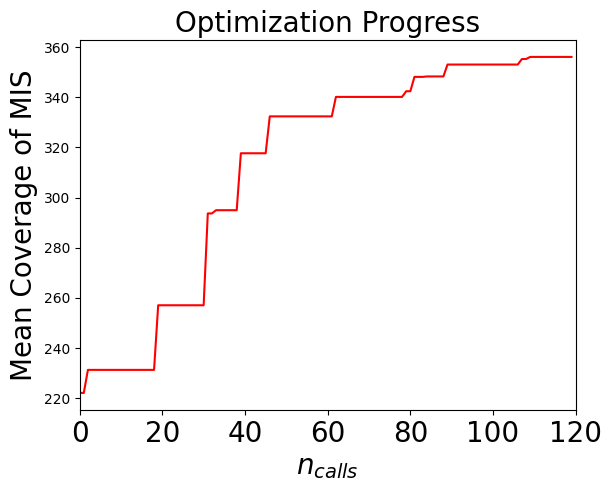

In [40]:
fig = plt.figure()
plt.plot(range(n_c), np.abs(sort_improv(RESULT)), "r-")
plt.title("Optimization Progress", fontsize=20)
plt.xlabel(r"$n_{calls}$", fontsize=20)
plt.ylabel("Mean Coverage of MIS", fontsize=20)
plt.xlim(0, n_c)
plt.xticks(fontsize=20)
plt.show()

In [41]:
# create register
reg = Register.from_coordinates(
    coords, center=False, prefix="q"
)
# add detuning map
det_map_from_reg = reg.define_detuning_map(
    {
        f"q{i}": RESULT.x[2*m+i] for i in range(n_weights)
    }  # mapping between qubit ids and weights
)
# Create a sequence
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(RESULT.x[:m], RESULT.x[m:m:2*m+1]), "ising")
# detuning waveform
total_duration = T
waveform = ConstantWaveform(total_duration, -delta_f/5)
# add detuning map
seq.config_detuning_map(det_map_from_reg, "dmm_0")
seq.add_dmm_detuning(waveform, "dmm_0")
# Run the simulation
simulator = QutipEmulator.from_sequence(seq, sampling_rate=0.5)
results = simulator.run(progress_bar=False)
# Get the final state
count_dict = results.sample_final_state(N_samples=N_samples)

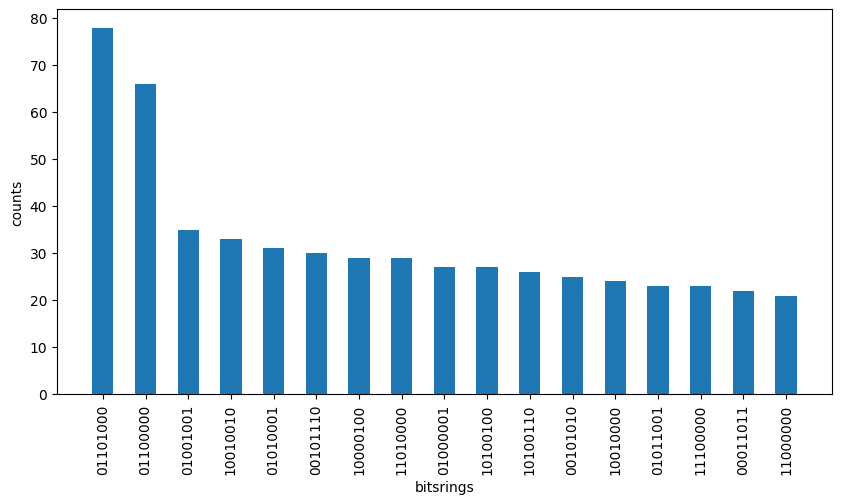

In [42]:
simulator = QutipEmulator.from_sequence(seq)
results = simulator.run()
results = simulator.run(progress_bar=False)
count_dict = results.sample_final_state(N_samples=N_samples)
most_frequent = {k:v for k,v in count_dict.items() if v>20}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()


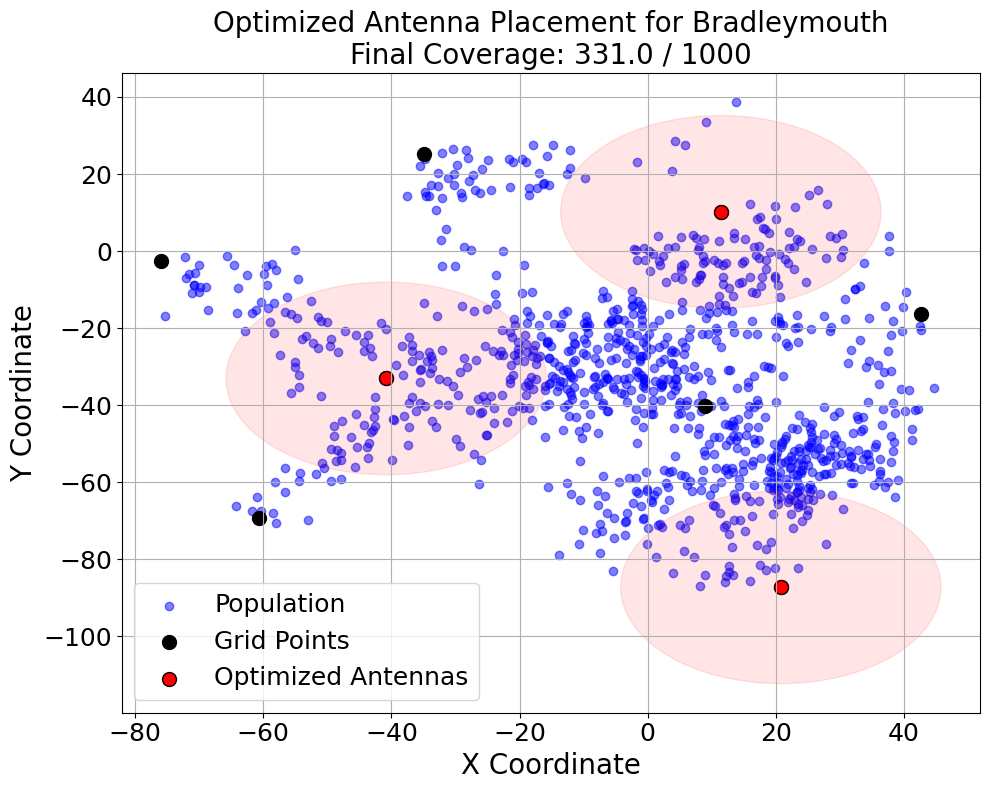

In [45]:
# Sort the bitstrings in descending order by frequency
solution = [key for key, value in sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)]

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

list_best_mis = [convert_to_indices(bitstring) for bitstring in solution]

# Extract the positions of the MIS nodes from the last solution
best_mis = list_best_mis[0]
final_positions = grid_points[best_mis]
R_antennas = 25

# Calculate coverage scores
real_coverage = np.sum(simple_coverage(population_x, population_y, final_positions, R_antennas))

# Plot: Optimized Grid and Population
plt.figure(figsize=(10, 8))
plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c='black', label='Grid Points', s=100, edgecolors='black')
plt.scatter(final_positions[:, 0], final_positions[:, 1], c='red', label='Optimized Antennas', s=100, edgecolors='black')

# Add coverage circles around each optimized antenna
for pos in final_positions:
    circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
    plt.gca().add_patch(circle)

# Set font sizes and labels
plt.xlabel('X Coordinate', fontsize=20)
plt.ylabel('Y Coordinate', fontsize=20)
plt.title(f'Optimized Antenna Placement for {city_name}\nFinal Coverage: {real_coverage} / {len(population_x)}', fontsize=20)
plt.legend(fontsize=18)
plt.tick_params(axis='both', labelsize=18)

plt.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.show()